# About Bollinger bands

What is:  Bollinger Bands are a type of price envelope developed by John BollingerOpens in a new window. (Price envelopes define upper and lower price range levels.)

# Importing data

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf 
from datetime import date, timedelta
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [2]:
asset = 'AMZN'
end_date = date.today()
start_date = end_date - timedelta(365*20) # 20 years

end_date, start_date

(datetime.date(2024, 2, 2), datetime.date(2004, 2, 7))

In [3]:
df = yf.download(asset, start_date, end_date)

df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-02-09,2.337500,2.340000,2.285000,2.293000,2.293000,122922000
2004-02-10,2.292500,2.312500,2.275500,2.279500,2.279500,98980000
2004-02-11,2.293000,2.368000,2.277000,2.357000,2.357000,157634000
2004-02-12,2.346500,2.405000,2.335500,2.353000,2.353000,135144000
2004-02-13,2.364500,2.385000,2.312000,2.319000,2.319000,108634000
...,...,...,...,...,...,...
2024-01-26,158.419998,160.720001,157.910004,159.119995,159.119995,51047400
2024-01-29,159.339996,161.289993,158.899994,161.259995,161.259995,45270400
2024-01-30,160.699997,161.729996,158.490005,159.000000,159.000000,45207400


# Calculating Bollinger bands

Steps:
- Calculate moving average from the last 20 days
- calculate standard deviation from the same period
- Calculate limit bands (top and botton)

- Top band: simple moving average + 2 times the standard deviation
- Botton band: simple moving average - 2 times the standard deviation

In [5]:
# Moving average and standard deviation

df['Moving average'] = df['Adj Close'].rolling(window = 20).mean()
df['Std dev'] = df['Adj Close'].rolling(window = 20).std()

# Top and botton band

df['Top band'] = df['Moving average'] + 2 * df['Std dev']
df['Botton band'] = df['Moving average'] - 2 * df['Std dev']

df = df.dropna()

In [6]:
df.sample(5)

,Open,High,Low,Close,Adj Close,Volume,Moving average,Std dev,Top band,Botton band
Date,,,,,,,,,,
2008-10-13,2.948000,3.110500,2.868500,3.1010,3.1010,223896000,3.415725,0.357099,4.129923,2.701527
2016-04-28,30.777000,31.340000,29.959999,30.1000,30.1000,157452000,30.564725,0.783011,32.130747,28.998703
2011-05-27,9.738000,9.806000,9.675000,9.7065,9.7065,47052000,9.912025,0.201466,10.314958,9.509092
2013-02-05,13.100000,13.401500,13.073000,13.3445,13.3445,80258000,13.461100,0.271705,14.004509,12.917691
2013-12-03,19.505501,19.547501,19.155001,19.2330,19.2330,74058000,18.389650,0.724453,19.838556,16.940744


<Axes: xlabel='Date'>

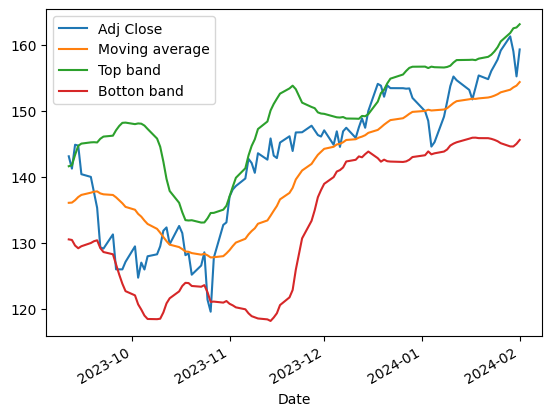

In [7]:
# Selected only 100 days just to see more clearly the chart
df[['Adj Close', 'Moving average', 'Top band', 'Botton band']].tail(100).plot()

# Long position

- Buy = price cross above top band
- Sell = price cross below top band OR stop loss of 10 days 

In [8]:
def long_position_dates(df, stop_loss_time):

    buy_dates = []
    sell_dates = []

    for i in range(1, len(df)): # Taking away the first element

        price_day_before = df.iloc[i-1]['Adj Close']
        price = df.iloc[i]['Adj Close']
        band_day_before = df.iloc[i-1]['Top band']
        band = df.iloc[i]['Top band']

        # This indicate that price crossed top band
        if (price_day_before < band_day_before) & (price >= band):

            try: # This is for those cases that it is on te last element of df
                buy_dates.append(df.iloc[i+1].name) # buy next day

                for j in range(1, stop_loss_time+1): # Stop loss of x days or crossed below
                    
                    try:
                        new_price_day_before = df.iloc[i+j-1]['Adj Close']
                        new_price = df.iloc[i+j]['Adj Close']
                        new_band_day_before = df.iloc[i+j-1]['Top band']
                        new_band = df.iloc[i+j]['Top band']

                        if (new_price_day_before > new_band_day_before) & (new_price <= new_band):
                            sell_dates.append(df.iloc[i+j+1].name) # sell next day
                            break
                            
                        elif j == stop_loss_time:
                            try:
                                sell_dates.append(df.iloc[i+j+1].name)
                            except:
                                sell_dates.append(df.iloc[-1].name) # this is for operations in the nearest x days
                    
                    except:
                        buy_dates.remove(df.iloc[i+1].name)
            except:
                'The last element error :('
                
    return [buy_dates, sell_dates]

In [9]:
lp_dates = long_position_dates(df, 30)

lp_buy_dates = lp_dates[0]
lp_sell_dates = lp_dates[1]

In [10]:
len(lp_buy_dates), len(lp_sell_dates)

(170, 170)

# Short position

- Sell = price cross below botton band
- Buy = price cross above botton band OR stop loss of 10 days 

In [11]:
def short_position_dates(df, stop_loss_time):

    buy_dates = []
    sell_dates = []

    for i in range(1, len(df)): # Taking away the first element

        price_day_before = df.iloc[i-1]['Adj Close']
        price = df.iloc[i]['Adj Close']
        band_day_before = df.iloc[i-1]['Botton band']
        band = df.iloc[i]['Botton band']

        if (price_day_before > band_day_before) & (price <= band):

            try: # This is for those cases that it is on te last element of df
                sell_dates.append(df.iloc[i+1].name) # sell the next day

                for j in range(1,stop_loss_time+1):

                    new_short_day_before = df.iloc[i+j-1]['Adj Close']
                    new_short = df.iloc[i+j]['Adj Close']
                    new_day_before = df.iloc[i+j-1]['Botton band']
                    new_day = df.iloc[i+j]['Botton band']

                    # This indicate that EMA short term crossed above long term EMA
                    if (new_short_day_before < new_day_before) & (new_short >= new_day):

                        buy_dates.append(df.iloc[i+j+1].name) # buy next day
                        break
                        
                    elif j == stop_loss_time:
                        try:
                            buy_dates.append(df.iloc[i+j+1].name)
                        except:
                            buy_dates.append(df.iloc[-1].name) # this is for operations in the nearest x days
            except:
                'The last element error :('

    return [buy_dates, sell_dates]

In [12]:
sp_dates = short_position_dates(df, 30)

sp_buy_dates = sp_dates[0]
sp_sell_dates = sp_dates[1]

In [13]:
len(sp_buy_dates), len(sp_sell_dates)

(116, 116)

# Comparison with buy and hold

In [14]:
buy_n_hold_return = ((df.iloc[-1]['Adj Close'] - df.iloc[0]['Adj Close']) / df.iloc[0]['Adj Close']) * 100
buy_n_hold_return

7223.2184952312455

In [15]:
def find_returns(df, b_dates, s_dates):

    operation_returns = []

    for i in range(len(b_dates)):
        
        buy_price = df.loc[b_dates[i]]['Adj Close']
        sell_price = df.loc[s_dates[i]]['Adj Close']

        operation_return = (sell_price - buy_price) / buy_price

        operation_returns.append(operation_return)
    
    return operation_returns

In [16]:
lp_return = find_returns(df, lp_buy_dates, lp_sell_dates)
sp_return = find_returns(df,sp_buy_dates, sp_sell_dates)

- Positives and negative returns

In [17]:
lp_win_returns = []
lp_lost_returns = []

for i in lp_return:
    if i > 0: lp_win_returns.append(i)
    if i < 0: lp_lost_returns.append(i)

In [18]:
sp_win_returns = []
sp_lost_returns = []

for i in sp_return:
    if i > 0: sp_win_returns.append(i)
    if i < 0: sp_lost_returns.append(i)

In [19]:
lp_perc_win = len(lp_win_returns) / len(lp_return) * 100
lp_perc_lost = len(lp_lost_returns) / len(lp_return) * 100

print(f'Long position winning trades: {round(lp_perc_win,2)}%')
print(f'Long position losing trades: {round(lp_perc_lost,2)}%')

Long position winning trades: 41.18%
Long position losing trades: 58.82%


In [20]:
sp_perc_win = len(sp_win_returns) / len(sp_return) * 100
sp_perc_lost = len(sp_lost_returns) / len(sp_return) * 100

print(f'Short position winning trades: {round(sp_perc_win,2)}%')
print(f'Short position losing trades: {round(sp_perc_lost,2)}%')

Short position winning trades: 42.24%
Short position losing trades: 56.9%


In [21]:
lp_average_win = np.mean(lp_win_returns)
lp_average_lost = np.mean(lp_lost_returns)

print(f'Average of long position winning trades: {round(lp_average_win,3)}% per trade')
print(f'Average of long position losing trades: {round(lp_average_lost,3)}% per trade')

Average of long position winning trades: 0.019% per trade
Average of long position losing trades: -0.018% per trade


In [22]:
sp_average_win = np.mean(sp_win_returns)
sp_average_lost = np.mean(sp_lost_returns)

print(f'Average of short position winning trades: {round(sp_average_win,3)}% per trade')
print(f'Average of short position losing trades: {round(sp_average_lost,3)}% per trade')

Average of short position winning trades: 0.033% per trade
Average of short position losing trades: -0.026% per trade


- Cumulative return

In [23]:
lp_cumulative_return = ((np.cumprod(1 + np.array(lp_return)) - 1) * 100)[-1]
lp_cumulative_return

-38.722840646602045

In [24]:
sp_cumulative_return = ((np.cumprod(1 + np.array(sp_return)) - 1) * 100)[-1]
sp_cumulative_return

-15.961235224292924

In [25]:
lp_sp_cumulative_return = np.mean([lp_cumulative_return, sp_cumulative_return])
lp_sp_cumulative_return

-27.342037935447486

- Bollinger bands vs Buy and Hold

In [26]:
print(f'Buy n hold return: {round(buy_n_hold_return,2)}%')
print(f'BB model return: {round(lp_sp_cumulative_return,2)}%')

Buy n hold return: 7223.22%
BB model return: -27.34%
